# Test1

Non-numeric columns found: ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']
Model saved as: random_forest_model.pkl
Model saved as: gradient_boosting_model.pkl
Model: Random Forest
Accuracy: 0.9949
AUC: 0.9997
                  precision    recall  f1-score   support

          Benign       1.00      1.00      1.00     42913
Anomalous (DDoS)       0.91      0.99      0.95      2236

        accuracy                           0.99     45149
       macro avg       0.96      0.99      0.97     45149
    weighted avg       1.00      0.99      0.99     45149



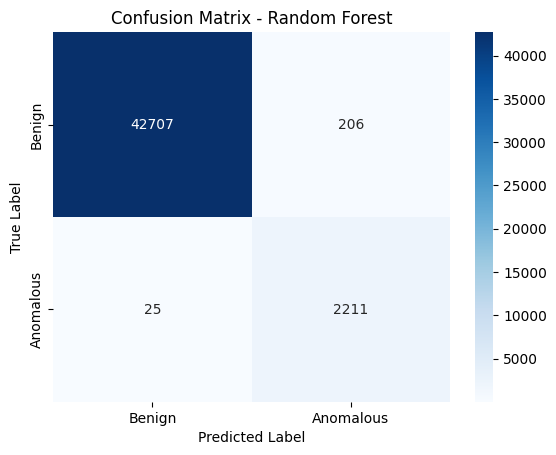

Model: Gradient Boosting
Accuracy: 0.9851
AUC: 0.9991
                  precision    recall  f1-score   support

          Benign       1.00      0.98      0.99     42913
Anomalous (DDoS)       0.77      1.00      0.87      2236

        accuracy                           0.99     45149
       macro avg       0.88      0.99      0.93     45149
    weighted avg       0.99      0.99      0.99     45149



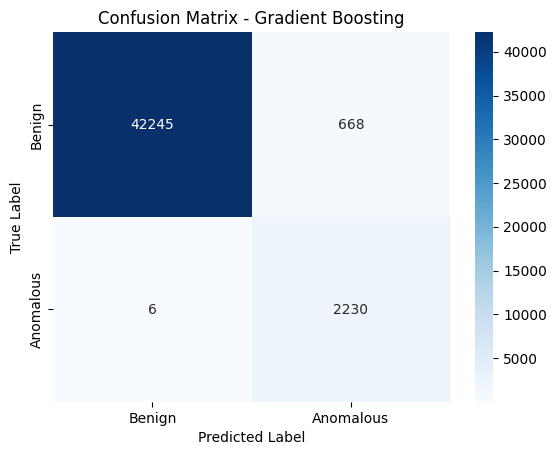

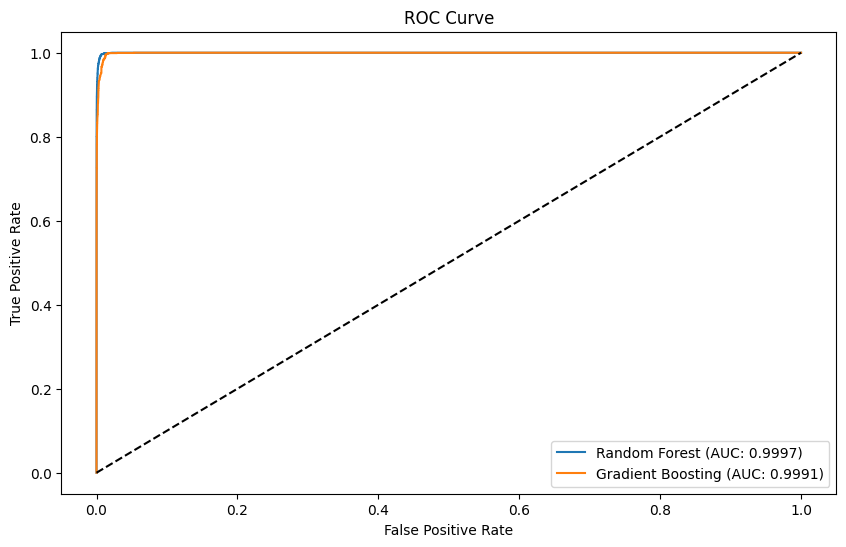

In [ ]:
# / friday-pcap.*cvs*
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading models

# Step 1: Load and Preprocess Dataset
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, on_bad_lines='skip')
    df.columns = df.columns.str.strip()  # Clean column names

    # Handle non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    if not non_numeric_cols.empty:
        print(f"Non-numeric columns found: {list(non_numeric_cols)}")
        df = df.drop(columns=non_numeric_cols, errors='ignore')

    if df.empty:
        raise ValueError("Dataset contains no numeric columns after preprocessing.")

    # Remove highly correlated features
    correlation_threshold = 0.9
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    df = df.drop(columns=to_drop, errors='ignore')

    # Scale numeric data
    numeric_df = df.select_dtypes(include=np.number)
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.median())
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    return df_scaled, numeric_df.columns

# Step 2: Anomaly Detection using Isolation Forest
def detect_anomalies(df_scaled, columns):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(df_scaled)
    predictions = model.predict(df_scaled)
    df_results = pd.DataFrame(df_scaled, columns=columns)
    df_results['Prediction'] = np.where(predictions == -1, 'Anomalous (DDoS)', 'Benign')
    df_results['Label'] = np.where(predictions == -1, 1, 0)
    return df_results

# Step 3: Handle Imbalanced Data with SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

# Step 4: Train Supervised Models with Hyperparameter Tuning
def train_supervised_models(df_results):
    X = df_results.drop(columns=['Prediction', 'Label'])
    y = df_results['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, y_train = balance_data(X_train, y_train)

    rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'class_weight': ['balanced']}
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
    rf_model.fit(X_train, y_train)

    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    return rf_model, gb_model, X_test, y_test

# Step 5: Save Trained Models
def save_models(models, filenames):
    for model, filename in zip(models, filenames):
        joblib.dump(model, filename)
        print(f"Model saved as: {filename}")

# Step 6: Load Models for Testing
def load_models(filenames):
    loaded_models = []
    for filename in filenames:
        model = joblib.load(filename)
        print(f"Model loaded: {filename}")
        loaded_models.append(model)
    return loaded_models

# Step 7: Evaluate Models
def evaluate_models(models, model_names, X_test, y_test):
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred, target_names=['Benign', 'Anomalous (DDoS)']))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Anomalous'], yticklabels=['Benign', 'Anomalous'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Step 8: Visualize ROC Curve
def plot_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    dataset_path = "/content/friday-pcap.csv"
    df_scaled, columns = load_and_preprocess_data(dataset_path)
    df_results = detect_anomalies(df_scaled, columns)

    rf_model, gb_model, X_test, y_test = train_supervised_models(df_results)

    models = [rf_model.best_estimator_, gb_model]
    model_names = ['Random Forest', 'Gradient Boosting']

    # Save models
    save_models(models, ['random_forest_model.pkl', 'gradient_boosting_model.pkl'])

    # Evaluate models
    evaluate_models(models, model_names, X_test, y_test)
    plot_roc_curve(models, model_names, X_test, y_test)

    # Load and predict on new data (if available)
    # Example:
    # new_data_path = "/content/new_test_data.csv"
    # new_df_scaled, _ = load_and_preprocess_data(new_data_path)
    # loaded_models = load_models(['random_forest_model.pkl', 'gradient_boosting_model.pkl'])
    # predict_new_data(loaded_models, model_names, new_df_scaled)


# Test2

Model saved as: random_forest_model.pkl
Model saved as: gradient_boosting_model.pkl
Model: Random Forest
Accuracy: 0.9945
AUC: 0.9996
                  precision    recall  f1-score   support

          Benign       1.00      1.00      1.00     26034
Anomalous (DDoS)       0.91      0.98      0.95      1315

        accuracy                           0.99     27349
       macro avg       0.95      0.99      0.97     27349
    weighted avg       0.99      0.99      0.99     27349



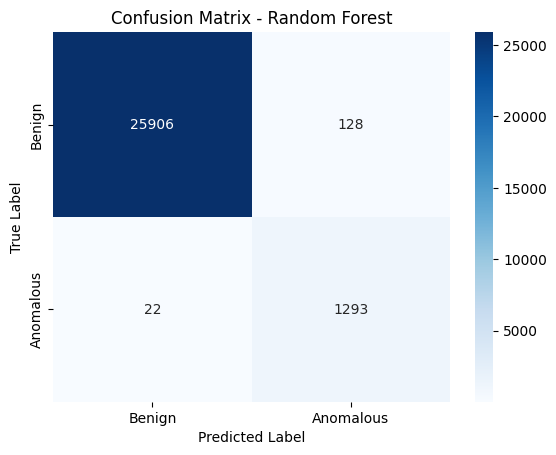

Model: Gradient Boosting
Accuracy: 0.9884
AUC: 0.9993
                  precision    recall  f1-score   support

          Benign       1.00      0.99      0.99     26034
Anomalous (DDoS)       0.81      0.99      0.89      1315

        accuracy                           0.99     27349
       macro avg       0.90      0.99      0.94     27349
    weighted avg       0.99      0.99      0.99     27349



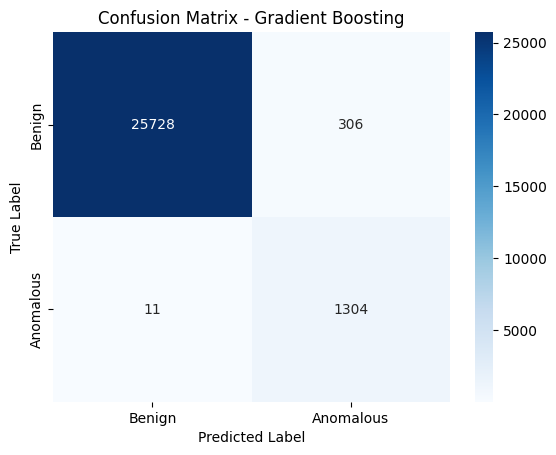

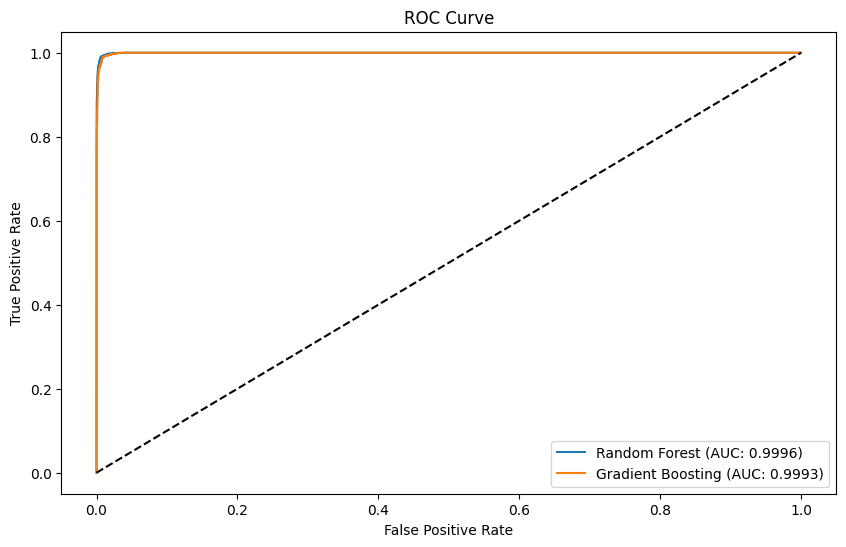

In [2]:
# / metasploitable.csv
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading models

# Step 1: Load and Preprocess Dataset
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, on_bad_lines='skip')
    df.columns = df.columns.str.strip()  # Clean column names

    # Handle non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    if not non_numeric_cols.empty:
        # print(f"Non-numeric columns found: {list(non_numeric_cols)}")
        df = df.drop(columns=non_numeric_cols, errors='ignore')

    if df.empty:
        raise ValueError("Dataset contains no numeric columns after preprocessing.")

    # Remove highly correlated features
    correlation_threshold = 0.9
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    df = df.drop(columns=to_drop, errors='ignore')

    # Scale numeric data
    numeric_df = df.select_dtypes(include=np.number)
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.median())
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    return df_scaled, numeric_df.columns

# Step 2: Anomaly Detection using Isolation Forest
def detect_anomalies(df_scaled, columns):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(df_scaled)
    predictions = model.predict(df_scaled)
    df_results = pd.DataFrame(df_scaled, columns=columns)
    df_results['Prediction'] = np.where(predictions == -1, 'Anomalous (DDoS)', 'Benign')
    df_results['Label'] = np.where(predictions == -1, 1, 0)
    return df_results

# Step 3: Handle Imbalanced Data with SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

# Step 4: Train Supervised Models with Hyperparameter Tuning
def train_supervised_models(df_results):
    X = df_results.drop(columns=['Prediction', 'Label'])
    y = df_results['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, y_train = balance_data(X_train, y_train)

    rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'class_weight': ['balanced']}
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
    rf_model.fit(X_train, y_train)

    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    return rf_model, gb_model, X_test, y_test

# Step 5: Save Trained Models
def save_models(models, filenames):
    for model, filename in zip(models, filenames):
        joblib.dump(model, filename)
        print(f"Model saved as: {filename}")

# Step 6: Load Models for Testing
def load_models(filenames):
    loaded_models = []
    for filename in filenames:
        model = joblib.load(filename)
        print(f"Model loaded: {filename}")
        loaded_models.append(model)
    return loaded_models

# Step 7: Evaluate Models
def evaluate_models(models, model_names, X_test, y_test):
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred, target_names=['Benign', 'Anomalous (DDoS)']))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Anomalous'], yticklabels=['Benign', 'Anomalous'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Step 8: Visualize ROC Curve
def plot_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    dataset_path = "/content/metasploitable-2.csv"
    df_scaled, columns = load_and_preprocess_data(dataset_path)
    df_results = detect_anomalies(df_scaled, columns)

    rf_model, gb_model, X_test, y_test = train_supervised_models(df_results)

    models = [rf_model.best_estimator_, gb_model]
    model_names = ['Random Forest', 'Gradient Boosting']

    # Save models
    save_models(models, ['random_forest_model.pkl', 'gradient_boosting_model.pkl'])

    # Evaluate models
    evaluate_models(models, model_names, X_test, y_test)
    plot_roc_curve(models, model_names, X_test, y_test)

    # Load and predict on new data (if available)
    # Example:
    # new_data_path = "/content/new_test_data.csv"
    # new_df_scaled, _ = load_and_preprocess_data(new_data_path)
    # loaded_models = load_models(['random_forest_model.pkl', 'gradient_boosting_model.pkl'])
    # predict_new_data(loaded_models, model_names, new_df_scaled)


# Test3

<ipython-input-1-3f9f60eddefc>:16: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, on_bad_lines='skip')


Model saved as: random_forest_model.pkl
Model saved as: gradient_boosting_model.pkl
Model: Random Forest
Accuracy: 0.9962
AUC: 0.9997
                  precision    recall  f1-score   support

          Benign       1.00      1.00      1.00     30284
Anomalous (DDoS)       0.95      0.98      0.96      1619

        accuracy                           1.00     31903
       macro avg       0.97      0.99      0.98     31903
    weighted avg       1.00      1.00      1.00     31903



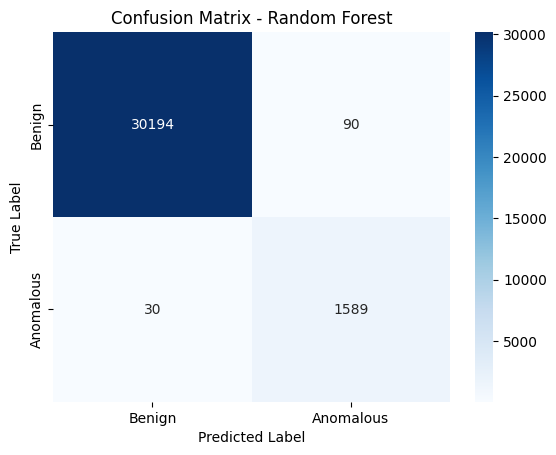

Model: Gradient Boosting
Accuracy: 0.9638
AUC: 0.9976
                  precision    recall  f1-score   support

          Benign       1.00      0.96      0.98     30284
Anomalous (DDoS)       0.58      1.00      0.74      1619

        accuracy                           0.96     31903
       macro avg       0.79      0.98      0.86     31903
    weighted avg       0.98      0.96      0.97     31903



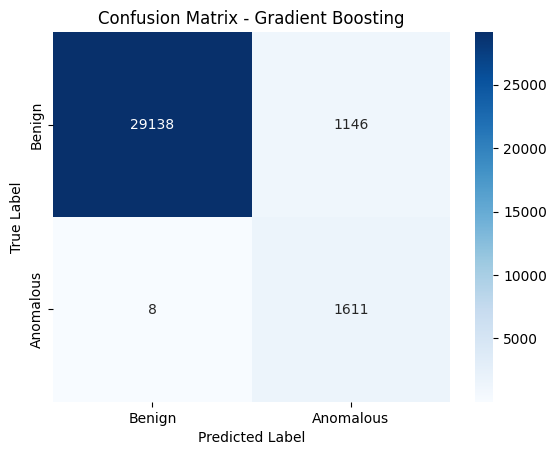

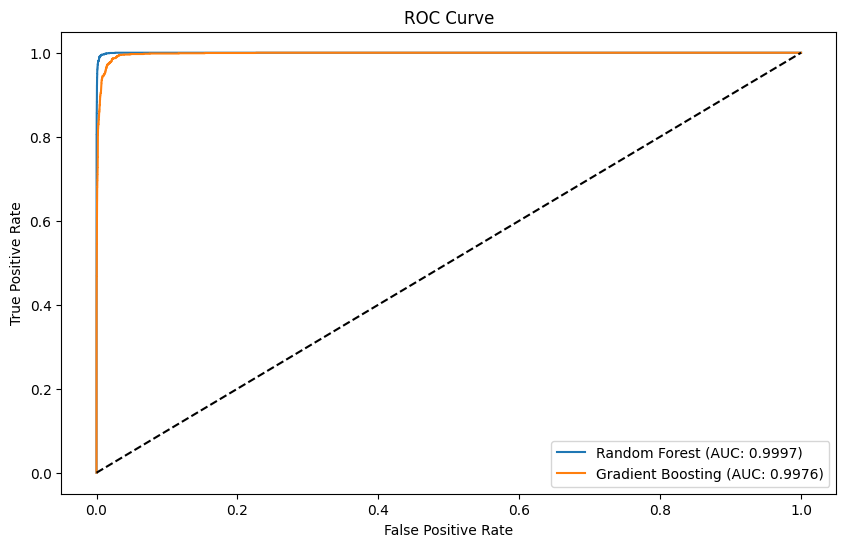

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading models

# Step 1: Load and Preprocess Dataset
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, on_bad_lines='skip')
    df.columns = df.columns.str.strip()  # Clean column names

    # Handle non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    if not non_numeric_cols.empty:
        print(f"Non-numeric columns found: {list(non_numeric_cols)}")
        df = df.drop(columns=non_numeric_cols, errors='ignore')

    if df.empty:
        raise ValueError("Dataset contains no numeric columns after preprocessing.")


    # Remove highly correlated features
    correlation_threshold = 0.9
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    df = df.drop(columns=to_drop, errors='ignore')

    # Scale numeric data
    numeric_df = df.select_dtypes(include=np.number)
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.median())
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    return df_scaled, numeric_df.columns

# Step 2: Anomaly Detection using Isolation Forest
def detect_anomalies(df_scaled, columns):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(df_scaled)
    predictions = model.predict(df_scaled)
    df_results = pd.DataFrame(df_scaled, columns=columns)
    df_results['Prediction'] = np.where(predictions == -1, 'Anomalous (DDoS)', 'Benign')
    df_results['Label'] = np.where(predictions == -1, 1, 0)
    return df_results

# Step 3: Handle Imbalanced Data with SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

# Step 4: Train Supervised Models with Hyperparameter Tuning
def train_supervised_models(df_results):
    X = df_results.drop(columns=['Prediction', 'Label'])
    y = df_results['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, y_train = balance_data(X_train, y_train)

    rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'class_weight': ['balanced']}
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
    rf_model.fit(X_train, y_train)

    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    return rf_model, gb_model, X_test, y_test

# Step 5: Save Trained Models
def save_models(models, filenames):
    for model, filename in zip(models, filenames):
        joblib.dump(model, filename)
        print(f"Model saved as: {filename}")

# Step 6: Load Models for Testing
def load_models(filenames):
    loaded_models = []
    for filename in filenames:
        model = joblib.load(filename)
        print(f"Model loaded: {filename}")
        loaded_models.append(model)
    return loaded_models

# Step 7: Evaluate Models
def evaluate_models(models, model_names, X_test, y_test):
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred, target_names=['Benign', 'Anomalous (DDoS)']))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Anomalous'], yticklabels=['Benign', 'Anomalous'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Step 8: Visualize ROC Curve
def plot_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    dataset_path = "/content/DDOS.csv"
    df_scaled, columns = load_and_preprocess_data(dataset_path)
    df_results = detect_anomalies(df_scaled, columns)

    rf_model, gb_model, X_test, y_test = train_supervised_models(df_results)

    models = [rf_model.best_estimator_, gb_model]
    model_names = ['Random Forest', 'Gradient Boosting']

    # Save models
    save_models(models, ['random_forest_model.pkl', 'gradient_boosting_model.pkl'])

    # Evaluate models
    evaluate_models(models, model_names, X_test, y_test)
    plot_roc_curve(models, model_names, X_test, y_test)

    # Load and predict on new data (if available)
    # Example:
    # new_data_path = "/content/new_test_data.csv"
    # new_df_scaled, _ = load_and_preprocess_data(new_data_path)
    # loaded_models = load_models(['random_forest_model.pkl', 'gradient_boosting_model.pkl'])
    # predict_new_data(loaded_models, model_names, new_df_scaled)


Non-numeric columns found: ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']
Model saved as: random_forest_model.pkl
Model saved as: gradient_boosting_model.pkl
Model: Random Forest
Accuracy: 0.9931
AUC: 0.9994
                  precision    recall  f1-score   support

          Benign       1.00      0.99      1.00     13059
Anomalous (DDoS)       0.89      0.97      0.93       626

        accuracy                           0.99     13685
       macro avg       0.94      0.98      0.96     13685
    weighted avg       0.99      0.99      0.99     13685



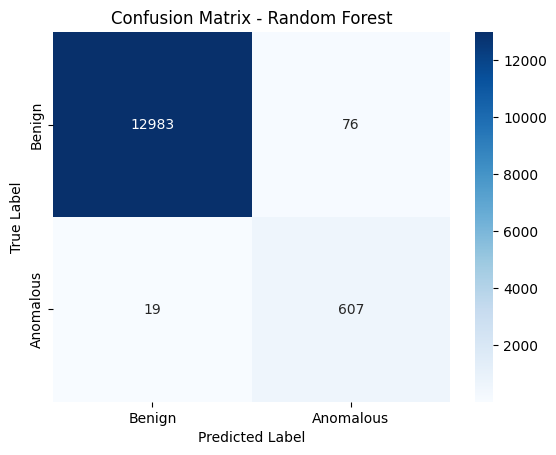

Model: Gradient Boosting
Accuracy: 0.9768
AUC: 0.9982
                  precision    recall  f1-score   support

          Benign       1.00      0.98      0.99     13059
Anomalous (DDoS)       0.67      0.98      0.80       626

        accuracy                           0.98     13685
       macro avg       0.83      0.98      0.89     13685
    weighted avg       0.98      0.98      0.98     13685



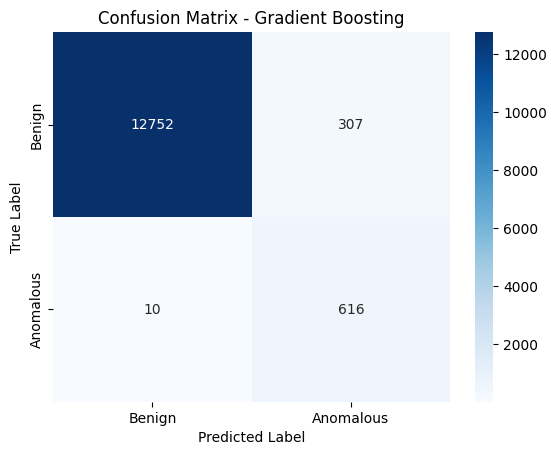

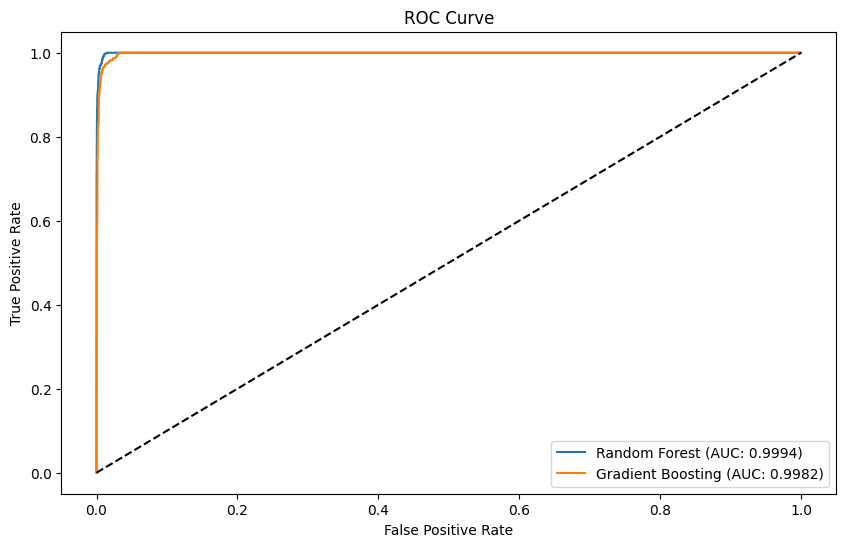

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading models

# Step 1: Load and Preprocess Dataset
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, on_bad_lines='skip')
    df.columns = df.columns.str.strip()  # Clean column names

    # Handle non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    if not non_numeric_cols.empty:
        print(f"Non-numeric columns found: {list(non_numeric_cols)}")
        df = df.drop(columns=non_numeric_cols, errors='ignore')

    if df.empty:
        raise ValueError("Dataset contains no numeric columns after preprocessing.")


    # Remove highly correlated features
    correlation_threshold = 0.9
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    df = df.drop(columns=to_drop, errors='ignore')

    # Scale numeric data
    numeric_df = df.select_dtypes(include=np.number)
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.median())
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    return df_scaled, numeric_df.columns

# Step 2: Anomaly Detection using Isolation Forest
def detect_anomalies(df_scaled, columns):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(df_scaled)
    predictions = model.predict(df_scaled)
    df_results = pd.DataFrame(df_scaled, columns=columns)
    df_results['Prediction'] = np.where(predictions == -1, 'Anomalous (DDoS)', 'Benign')
    df_results['Label'] = np.where(predictions == -1, 1, 0)
    return df_results

# Step 3: Handle Imbalanced Data with SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

# Step 4: Train Supervised Models with Hyperparameter Tuning
def train_supervised_models(df_results):
    X = df_results.drop(columns=['Prediction', 'Label'])
    y = df_results['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, y_train = balance_data(X_train, y_train)

    rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'class_weight': ['balanced']}
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
    rf_model.fit(X_train, y_train)

    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    return rf_model, gb_model, X_test, y_test

# Step 5: Save Trained Models
def save_models(models, filenames):
    for model, filename in zip(models, filenames):
        joblib.dump(model, filename)
        print(f"Model saved as: {filename}")

# Step 6: Load Models for Testing
def load_models(filenames):
    loaded_models = []
    for filename in filenames:
        model = joblib.load(filename)
        print(f"Model loaded: {filename}")
        loaded_models.append(model)
    return loaded_models

# Step 7: Evaluate Models
def evaluate_models(models, model_names, X_test, y_test):
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred, target_names=['Benign', 'Anomalous (DDoS)']))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Anomalous'], yticklabels=['Benign', 'Anomalous'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Step 8: Visualize ROC Curve
def plot_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    dataset_path = "/content/Normal_data.csv"
    df_scaled, columns = load_and_preprocess_data(dataset_path)
    df_results = detect_anomalies(df_scaled, columns)

    rf_model, gb_model, X_test, y_test = train_supervised_models(df_results)

    models = [rf_model.best_estimator_, gb_model]
    model_names = ['Random Forest', 'Gradient Boosting']

    # Save models
    save_models(models, ['random_forest_model.pkl', 'gradient_boosting_model.pkl'])

    # Evaluate models
    evaluate_models(models, model_names, X_test, y_test)
    plot_roc_curve(models, model_names, X_test, y_test)

    # Load and predict on new data (if available)
    # Example:
    # new_data_path = "/content/new_test_data.csv"
    # new_df_scaled, _ = load_and_preprocess_data(new_data_path)
    # loaded_models = load_models(['random_forest_model.pkl', 'gradient_boosting_model.pkl'])
    # predict_new_data(loaded_models, model_names, new_df_scaled)


<ipython-input-1-523b9f395524>:16: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, on_bad_lines='skip')


Non-numeric columns found: ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Total Length of Bwd Packets', 'Label']
Model saved as: random_forest_model.pkl
Model saved as: gradient_boosting_model.pkl
Model: Random Forest
Accuracy: 0.9754
AUC: 0.9988
                  precision    recall  f1-score   support

          Benign       1.00      0.97      0.99     30284
Anomalous (DDoS)       0.67      0.99      0.80      1619

        accuracy                           0.98     31903
       macro avg       0.84      0.98      0.90     31903
    weighted avg       0.98      0.98      0.98     31903



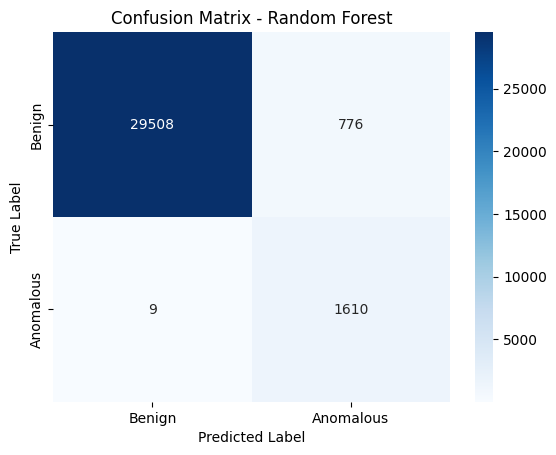

Model: Gradient Boosting
Accuracy: 0.9638
AUC: 0.9976
                  precision    recall  f1-score   support

          Benign       1.00      0.96      0.98     30284
Anomalous (DDoS)       0.58      1.00      0.74      1619

        accuracy                           0.96     31903
       macro avg       0.79      0.98      0.86     31903
    weighted avg       0.98      0.96      0.97     31903



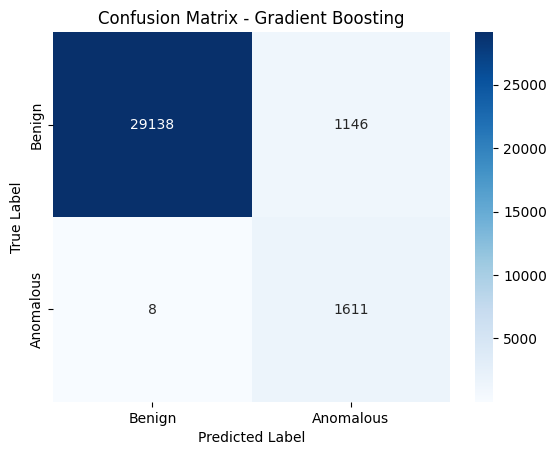

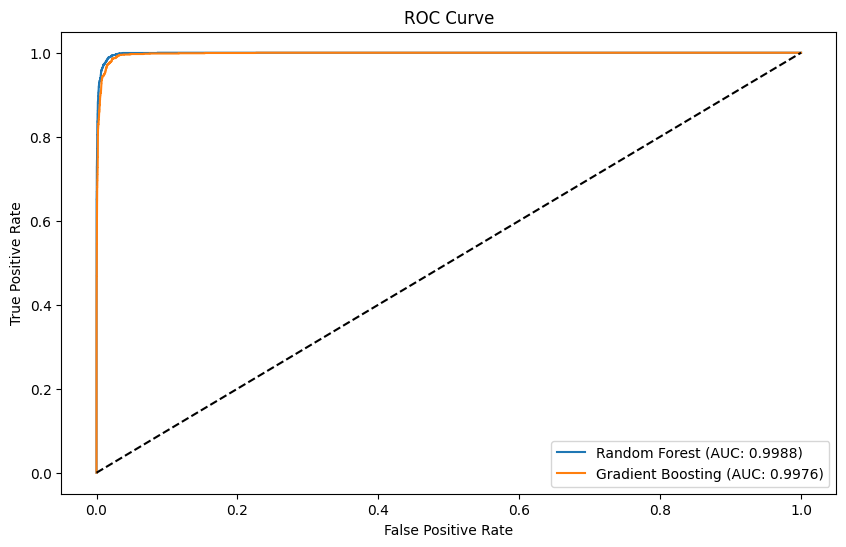

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading models

# Step 1: Load and Preprocess Dataset
def load_and_preprocess_data(filepath):
    # Load dataset
    df = pd.read_csv(filepath, on_bad_lines='skip')
    df.columns = df.columns.str.strip()  # Clean column names

    # Handle non-numeric columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns
    if not non_numeric_cols.empty:
        print(f"Non-numeric columns found: {list(non_numeric_cols)}")
        df = df.drop(columns=non_numeric_cols, errors='ignore')

    if df.empty:
        raise ValueError("Dataset contains no numeric columns after preprocessing.")


    # Remove highly correlated features
    correlation_threshold = 0.9
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    df = df.drop(columns=to_drop, errors='ignore')

    # Scale numeric data
    numeric_df = df.select_dtypes(include=np.number)
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).fillna(numeric_df.median())
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    return df_scaled, numeric_df.columns

# Step 2: Anomaly Detection using Isolation Forest
def detect_anomalies(df_scaled, columns):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(df_scaled)
    predictions = model.predict(df_scaled)
    df_results = pd.DataFrame(df_scaled, columns=columns)
    df_results['Prediction'] = np.where(predictions == -1, 'Anomalous (DDoS)', 'Benign')
    df_results['Label'] = np.where(predictions == -1, 1, 0)
    return df_results

# Step 3: Handle Imbalanced Data with SMOTE
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced

# Step 4: Train Supervised Models with Hyperparameter Tuning
def train_supervised_models(df_results):
    X = df_results.drop(columns=['Prediction', 'Label'])
    y = df_results['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, y_train = balance_data(X_train, y_train)

    # Train Random Forest without GridSearchCV
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        max_depth=10,      # Maximum depth of each tree
        class_weight='balanced',  # Handle imbalanced data
        random_state=42    # Reproducibility
    )
    rf_model.fit(X_train, y_train)

    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    return rf_model, gb_model, X_test, y_test

# Step 5: Save Trained Models
def save_models(models, filenames):
    for model, filename in zip(models, filenames):
        joblib.dump(model, filename)
        print(f"Model saved as: {filename}")

# Step 6: Load Models for Testing
def load_models(filenames):
    loaded_models = []
    for filename in filenames:
        model = joblib.load(filename)
        print(f"Model loaded: {filename}")
        loaded_models.append(model)
    return loaded_models

# Step 7: Evaluate Models
def evaluate_models(models, model_names, X_test, y_test):
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred, target_names=['Benign', 'Anomalous (DDoS)']))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Anomalous'], yticklabels=['Benign', 'Anomalous'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Step 8: Visualize ROC Curve
def plot_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    dataset_path = "/content/DDOS.csv"
    df_scaled, columns = load_and_preprocess_data(dataset_path)
    df_results = detect_anomalies(df_scaled, columns)

    rf_model, gb_model, X_test, y_test = train_supervised_models(df_results)

    models = [rf_model, gb_model]
    model_names = ['Random Forest', 'Gradient Boosting']

    # Save models
    save_models(models, ['random_forest_model.pkl', 'gradient_boosting_model.pkl'])

    # Evaluate models
    evaluate_models(models, model_names, X_test, y_test)
    plot_roc_curve(models, model_names, X_test, y_test)

    # Load and predict on new data (if available)
    # Example:
    # new_data_path = "/content/new_test_data.csv"
    # new_df_scaled, _ = load_and_preprocess_data(new_data_path)
    # loaded_models = load_models(['random_forest_model.pkl', 'gradient_boosting_model.pkl'])
    # predict_new_data(loaded_models, model_names, new_df_scaled)
